# Miniproject 2 - Mini deep-learning framework

In [1]:
import torch
import math
torch.set_grad_enabled(False);

## Create Modules

In [2]:
class Module(object):
    def forward(self, *input):
        raise NotImplementedError
    
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
    
    def param(self): 
        return []
    
    def zero_grad(self):
        pass

In [55]:
class Linear(Module):
    
    def __init__(self, inp, out):
        #check if in and out > 0
        #check if in and out are int
        
        self.X = None
        
        self.num_in = inp
        self.num_out = out
        
        
        self.weights = torch.empty((self.num_in, self.num_out)).normal_()
        self.weights_grad = torch.empty((self.num_in, self.num_out)).zero_()
        
        self.bias = torch.empty((1, self.num_out)).normal_()
        self.bias_grad = torch.empty((1, self.num_out)).zero_()
        
    def forward(self, inp):
        """
        inp: (-1 ,num_in)
        """
        
        #check if inp is correct format
        
        self.X = inp
        return inp.mm(self.weights) + self.bias
    
    def backward(self, gradient):
        """
        outp: (-1, num_out)
        """
        self.weights_grad += self.X.T.mm(gradient)
        #Gradient with regards to the output is always 1 for the bias
        self.bias_grad += self.bias.sum(1).unsqueeze(1)
        
        return gradient.mm(self.weights.T)
    
    def param(self):
        return [(self.weights, self.weights_grad), (self.bias, self.bias_grad)]
    
    def zero_grad(self):
        self.weights_grad.zero_()
        self.bias_grad.zero_()

In [58]:
class ReLu(Module):
    def __init__(self):
        self.X = None
    
    def forward(self, inp):
        self.X = inp
        
        #Set lower bound to 0
        return inp.clamp(min=0.0)
    
    def backward(self, gradient):
        return gradient.mul((self.X > 0).float())
    

In [59]:
class Tanh(Module):
    def __init__(self):
        self.X = None
        
    def forward(self, inp):
        self.X = inp
        
        return inp.tanh()
    
    def backward(self, gradient):
        # derivative of tanh is: 1 - tanh(x)^2
        derivative = 1 - self.X.tanh().pow(2)
        return gradient.mul(derivative)

    

In [177]:
class LossMSE(Module):
    def __init__(self):
        self.pred = None
        self.target = None
        self.size = None
    def forward(self, pred, gt):
        self.pred, self.target, self.size = pred, gt, pred.size()[1]
        return (self.pred - self.target).pow(2).sum() / self.size
    def backward(self):
        return (2 / self.size) * (self.pred - self.target)

In [178]:
class Sequential(Module):
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, inp):
        X = inp.clone()
        for module in self.layers:
            X = module.forward(X)
        return X
    
    def backward(self, outp):
        Y = outp.clone()
        for module in reversed(self.layers):
            Y = module.backward(Y)
        return Y
    
    def param(self):
        return [param for layer in self.layers for param in layer.param()]
    
    def zero_grad(self):
        for module in self.layers:
            module.zero_grad()

In [179]:
class SGD_optimizer():
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr
        
    def step(self):
        for p, grad_p in self.params:
            p.sub_(self.lr*grad_p)

## Generate data

In [180]:
def generate_labels(tensor, center_x=0.5, center_y=0.5, r=1/math.sqrt(2 * math.pi)):
    dist = (tensor[:,0] - center_x).pow(2) + (tensor[:, 1] - center_y).pow(2)
    return (dist <= math.pow(r, 2)).long()

In [181]:
def generate_data(n=1000, seed=0):
    train, test = torch.empty((1000,2)).uniform_(0,1), torch.empty((1000,2)).uniform_(0,1)
    train_label, test_label = generate_labels(train), generate_labels(test)
    
    return train, train_label, test, test_label

In [182]:
import matplotlib.pyplot as plt
import matplotlib
train, train_labels, test, test_labels = generate_data()

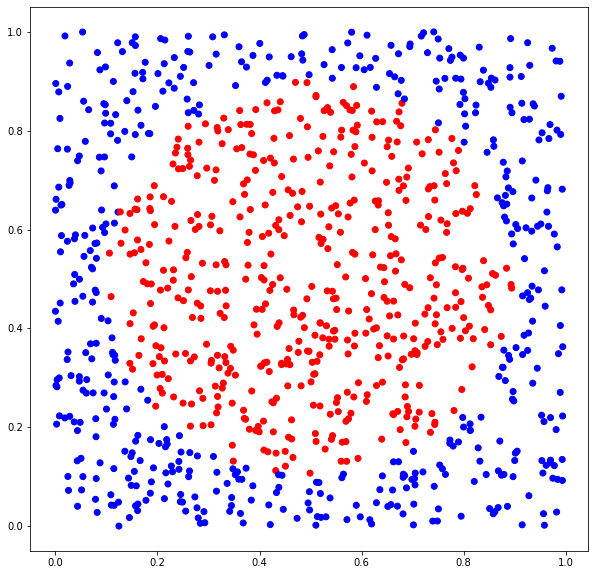

In [183]:
plt.figure(figsize=(10,10))
plt.scatter(train[:,0], train[:,1], c=train_labels, cmap=matplotlib.colors.ListedColormap(['blue', 'red']));

In [195]:
def plot_train_vs_test(train_acc, test_acc, train_loss, test_loss):
    best_ind = test_acc.index(max(test_acc)) + 1
    plt.plot(list(range(1, len(train_acc) + 1)), train_acc, color="blue", label="train")
    plt.plot(list(range(1, len(test_acc) + 1)), test_acc, color="red", label="test")
    plt.vlines(best_ind, 0, 1, label="best epoch = {0}".format(best_ind))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy given epoch for train dataset (blue) and test dataset (red)")
    plt.legend()
    plt.figure()
    ######
    plt.plot(list(range(1, len(train_loss) + 1)), train_loss, color="blue", label="train")
    plt.plot(list(range(1, len(test_loss) + 1)), test_loss, color="red", label="test")
    plt.vlines(best_ind, 0, max(test_loss), label="best epoch = {0}".format(best_ind))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss given epoch for train dataset (blue) and test dataset (red)")
    plt.legend()
    plt.figure()

## Create model

In [184]:
def convert_to_one_hot_labels(inp, classes):
    tmp = inp.new_zeros(classes.size(0), classes.max() + 1)
    tmp.scatter_(1, classes.view(-1, 1), 1.0)
    return tmp

In [185]:
train_classes = convert_to_one_hot_labels(train, train_labels)
test_classes = convert_to_one_hot_labels(test, test_labels)

In [211]:
N_EPOCH = 300
BATCH_SIZE = 5
LR = 0.001

def fit(train_input, train_target, test_input, test_target, loss_func, model, optim, lr=LR, batch_size=BATCH_SIZE, epochs=N_EPOCH):
    dataset = torch.utils.data.TensorDataset(train_input, train_target)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_accs, train_losses = [], []
    test_accs, test_losses = [], []
    max_acc, best_epoch = -1, -1

    for epoch in range(N_EPOCH):
        running_loss = 0
        correct = 0
        for batch in loader:
            batch_x, batch_y = batch
            pred = model.forward(batch_x)
            running_loss += loss_func.forward(pred, batch_y)
            
            pred_classes = pred.max(1)[1]
            gt_classes = batch_y.max(1)[1]
            correct += (pred_classes == gt_classes).float().sum()
            
            # Backward
            model.zero_grad()
            model.backward(loss_func.backward())
            optimizer.step()
            
        #Test
        test_preds = model.forward(test_input)
        test_loss = loss_func.forward(test_preds, test_target)
        test_acc = (test_preds.max(1)[1] == test_target.max(1)[1]).float().sum() / test_input.size(0)
        
        # Save results
        train_losses.append(running_loss)
        train_accs.append(correct/train_input.size(0))
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch}',
                  'Train loss: {:.5f}'.format(train_losses[-1]),
                  f'Train accuracy: {train_accs[-1]}',
                  'Test loss: {:.5f}'.format(test_losses[-1]),
                  f'Test accuracy: {test_accs[-1]}',
                  sep='\t')
    plot_train_vs_test(train_accs, test_accs, train_losses, test_losses)
    return train_accs, train_losses, test_accs, test_losses

Epoch: 0	Train loss: 848.88531	Train accuracy: 0.550000011920929	Test loss: 367.61038	Test accuracy: 0.6240000128746033
Epoch: 10	Train loss: 110.35584	Train accuracy: 0.8840000033378601	Test loss: 119.84904	Test accuracy: 0.8799999952316284
Epoch: 20	Train loss: 51.97509	Train accuracy: 0.9620000123977661	Test loss: 58.84734	Test accuracy: 0.9430000185966492
Epoch: 30	Train loss: 43.32738	Train accuracy: 0.9639999866485596	Test loss: 58.74342	Test accuracy: 0.9359999895095825
Epoch: 40	Train loss: 40.05690	Train accuracy: 0.9670000076293945	Test loss: 50.10392	Test accuracy: 0.9440000057220459
Epoch: 50	Train loss: 39.93776	Train accuracy: 0.9610000252723694	Test loss: 45.95966	Test accuracy: 0.9470000267028809
Epoch: 60	Train loss: 37.03589	Train accuracy: 0.9700000286102295	Test loss: 44.68561	Test accuracy: 0.9599999785423279
Epoch: 70	Train loss: 34.41466	Train accuracy: 0.9700000286102295	Test loss: 44.93744	Test accuracy: 0.9570000171661377
Epoch: 80	Train loss: 34.55301	Train a

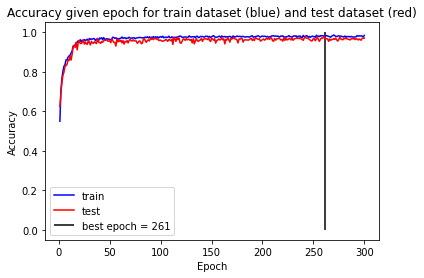

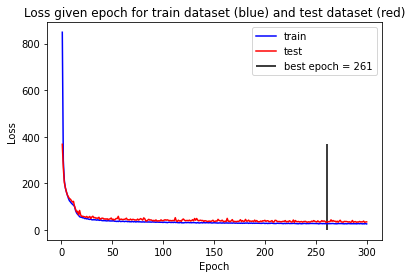

<Figure size 432x288 with 0 Axes>

In [212]:
layer1 = Linear(2, 25)
layer2 = Linear(25, 25)
layer3 = Linear(25, 25)
layer4 = Linear(25, 2)

model = Sequential([layer1, ReLu(), layer2, ReLu(), layer3, Tanh(), layer4, Tanh()])
loss = LossMSE()
outp = model.forward(train)
optimizer = SGD_optimizer(model.param(), LR)
train_accs, train_losses, test_accs, test_losses = fit(train, train_classes, test, test_classes, loss, model, optim=optimizer);